In [156]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [157]:
# Get csv file 
relact = pd.read_csv("data/FlA_ZP_RelAct_full.csv", sep=";")


# Filter for the reference condition (Protein == "WT")
reference = relact[relact["Protein"] == "WT"]

# Merge the reference values back into the original DataFrame based on the same condition
relact = relact.merge(
    reference[["Plate", "Time(min)", "SAM_conc(uM)", "Replicate", "%SAM_converted"]],
    on=["Plate", "Time(min)", "SAM_conc(uM)", "Replicate"],
    suffixes=("", "_ref"),
    how="left"
)

# Calculate Relative_Activity
relact["Relative_Activity"] = relact["%SAM_converted"] / relact["%SAM_converted_ref"]

# Drop the intermediate reference column 
relact.drop(columns=["%SAM_converted_ref"], inplace=True)

relact_var = relact.drop(relact.index[relact["Protein"] == "WT"].tolist())

In [158]:
# Get csv file with model rankings
ZP_pred = pd.read_csv("data/FlA_HIM_SMscan_full_sorted_ESM1b&TranceptEVE&ESM-IF1.csv", sep=";") 

# Add bin and rank columns for each model
relact_var_models = relact_var.merge(
    ZP_pred[["mutant", "ESM1b_bin", "ESM1b_rank", "ESM1b_score", "TranceptEVE_bin", "TranceptEVE_rank", "TranceptEVE_score", "ESM-IF1_bin", "ESM-IF1_rank", "ESM-IF1_score"]],
    left_on="Protein", right_on="mutant",
    how="left"
)

relact_var_models = relact_var_models.dropna(subset="mutant") ### drop all variants that werent in the dataset predicted by the ZSM

relact_var_models.drop(columns=["mutant"], inplace=True)

# Add selection metrics for testing 
singles = ["ESM1b", "TranceptEVE", "ESM-IF1"]
doubles = ["ESM1b_TranceptEVE", "ESM1b_ESM-IF1", "TranceptEVE_ESM-IF1"]

for model in singles:
    relact_var_models[model] = [True if rank <= 10 else False for rank in relact_var_models[f"{model}_rank"]] ### if rank is equal to or higher than 10, counts to that model
    
for model in doubles:
    bins = model.split("_")
    relact_var_models[model] = False ### initialize column
    relact_var_models.loc[(relact_var_models[f"{bins[0]}_bin"] == 1) & (relact_var_models[f"{bins[1]}_bin"] == 1), model] = True ### if both models predict as faster variant, counts to that model


# Get TranceptEVE_ESM-IF1 combined rank score
relact_var_models["ESM1b_TranceptEVE_rank"] = relact_var_models["ESM1b_rank"] + relact_var_models["TranceptEVE_rank"]
relact_var_models["ESM1b_ESM-IF1_rank"] = relact_var_models["ESM1b_rank"] + relact_var_models["ESM-IF1_rank"]
relact_var_models["TranceptEVE_ESM-IF1_rank"] = relact_var_models["TranceptEVE_rank"] + relact_var_models["ESM-IF1_rank"]

relact_var_models["TranceptEVE_ESM-IF1"] = [True if rank <= 116 else False for rank in relact_var_models["TranceptEVE_ESM-IF1_rank"]] ### Special treatment for this combination: only top ten when combining rankings are included in model     

In [159]:
### Save intermediate dataset
relact_var_models.to_csv("data/FlA_ZP_Relact_var.csv")

In [160]:
### Add Abou's dataset to the DataFrame
abou_data = pd.read_csv("data/FlA_HIM_relativeActivity.csv", sep=";")
temp = pd.DataFrame({
    "Sample_ID": abou_data["Name"].tolist(), 
    "Relative_Activity": abou_data["Relative activity (%)"].tolist()
})

### Convert from percentage
temp["Relative_Activity"] = temp["Relative_Activity"]/100

relact_comb = pd.concat([relact_var_models, temp], ignore_index=True)

### Add reaction data
relact_comb["Time(min)"] = relact_comb["Time(min)"].fillna(180)
relact_comb["SAM_conc(uM)"] = relact_comb["SAM_conc(uM)"].fillna(300)

### Assign false for all models 
models = ["ESM1b", "TranceptEVE", "ESM-IF1", "ESM1b_TranceptEVE", "ESM1b_ESM-IF1", "TranceptEVE_ESM-IF1"]
for model in models:
    relact_comb[model] = relact_comb[model].fillna(False)

### Create new category for selection dataset
relact_comb["Selection_Dataset"] = False
relact_comb["Selection_Dataset"] = relact_comb["Sample_ID"].str.contains("HiM", case=False)

/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_10598/395057998.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  relact_comb[model] = relact_comb[model].fillna(False)


In [162]:
relact_var_models

,Sample_ID,Plate,Protein,Time(min),SAM_conc(uM),Replicate,Inj_Vol(ul),Dilution,FDA_Area,SAM_Area,...,ESM-IF1_score,ESM1b,TranceptEVE,ESM-IF1,ESM1b_TranceptEVE,ESM1b_ESM-IF1,TranceptEVE_ESM-IF1,ESM1b_TranceptEVE_rank,ESM1b_ESM-IF1_rank,TranceptEVE_ESM-IF1_rank
0,L17F_2min_300uM_1,ZP1-3,L17F,2,300,1,20,2,0.0248,37.2761,...,-1.090612,False,False,False,False,False,False,232.0,117.0,247.0
1,L17F_2min_300uM_2,ZP1-3,L17F,2,300,2,20,2,0.0200,32.5963,...,-1.090612,False,False,False,False,False,False,232.0,117.0,247.0
2,L17F_5min_300uM_1,ZP1-3,L17F,5,300,1,20,2,0.0624,37.9499,...,-1.090612,False,False,False,False,False,False,232.0,117.0,247.0
3,L17F_5min_300uM_2,ZP1-3,L17F,5,300,2,20,2,0.0617,34.2594,...,-1.090612,False,False,False,False,False,False,232.0,117.0,247.0
4,L17F_3h_300uM_1,ZP1-3,L17F,180,300,1,20,2,1.2395,33.3191,...,-1.090612,False,False,False,False,False,False,232.0,117.0,247.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,H32L_3h_10uM_3,ZP_Rep2-2,H32L,180,10,3,20,2,0.8874,0.3653,...,-1.090890,False,True,False,False,False,True,179.0,244.0,79.0
805,S158G_3h_10uM_3,ZP_Rep2-2,S158G,180,10,3,20,2,0.0783,1.2068,...,-1.081796,False,False,True,False,False,False,323.0,103.0,230.0
806,F190I_3h_10uM_3,ZP_Rep2-2,F190I,180,10,3,20,2,0.8824,0.3561,...,-1.077220,False,False,True,False,False,False,1643.0,1004.0,645.0
807,F65V_3h_10uM_3,ZP_Rep2-2,F65V,180,10,3,20,2,0.7686,0.4039,...,-1.073169,False,False,True,False,False,False,3753.0,1104.0,2651.0


In [170]:
#Set timepoint and SAM conc.
t=2 # [2,5,180]
SAM=300 # [10,300]

#Plotting - boxplot over different models
subset_2 = relact_comb.loc[(relact_comb["Time(min)"] == t) & (relact_comb["SAM_conc(uM)"] == SAM)]
subset_2_ordered = pd.DataFrame(
    {
        "Selection": subset_2.loc[subset_2["Selection_Dataset"], "Relative_Activity"],
        "ESM1b": subset_2.loc[subset_2["ESM1b"], "Relative_Activity"],
        "TranceptEVE": subset_2.loc[subset_2["TranceptEVE"], "Relative_Activity"],
        "ESM-IF1": subset_2.loc[subset_2["ESM-IF1"], "Relative_Activity"],
        "ESM1b_TranceptEVE": subset_2.loc[subset_2["ESM1b_TranceptEVE"], "Relative_Activity"],
        "ESM1b_ESM-IF1": subset_2.loc[subset_2["ESM1b_ESM-IF1"], "Relative_Activity"],
        "TranceptEVE_ESM-IF1": subset_2.loc[subset_2["TranceptEVE_ESM-IF1"], "Relative_Activity"]
    }
)


#Set timepoint and SAM conc.
t=180 # [2,5,180]
SAM=300 # [10,300]

#Plotting - boxplot over different models
subset_180 = relact_comb.loc[(relact_comb["Time(min)"] == t) & (relact_comb["SAM_conc(uM)"] == SAM)]
subset_180_ordered = pd.DataFrame(
    {
        "Selection": subset_180.loc[subset_180["Selection_Dataset"], "Relative_Activity"],
        "ESM1b": subset_180.loc[subset_180["ESM1b"], "Relative_Activity"],
        "TranceptEVE": subset_180.loc[subset_180["TranceptEVE"], "Relative_Activity"],
        "ESM-IF1": subset_180.loc[subset_180["ESM-IF1"], "Relative_Activity"],
        "ESM1b_TranceptEVE": subset_180.loc[subset_180["ESM1b_TranceptEVE"], "Relative_Activity"],
        "ESM1b_ESM-IF1": subset_180.loc[subset_180["ESM1b_ESM-IF1"], "Relative_Activity"],
        "TranceptEVE_ESM-IF1": subset_180.loc[subset_180["TranceptEVE_ESM-IF1"], "Relative_Activity"]
    }
)

In [179]:
subset_180_mean = {}
subset_180_std = {}
subset_2_mean = {}
subset_2_std = {}
models = ["ESM1b", "TranceptEVE", "ESM-IF1", "ESM1b_TranceptEVE", "ESM1b_ESM-IF1", "TranceptEVE_ESM-IF1"]
for model in models:
    mean_ = [subset_180.loc[subset_180["Protein"] == prot, "Relative_Activity"].mean() for prot in pd.unique(subset_180.loc[subset_180[model], ["Relative_Activity",'Protein']].Protein)]
    std_ = [subset_180.loc[subset_180["Protein"] == prot, "Relative_Activity"].std() for prot in pd.unique(subset_180.loc[subset_180[model], ["Relative_Activity",'Protein']].Protein)]
    subset_180_mean[model] = mean_
    subset_180_std[model] = std_

    mean_ = [subset_2.loc[subset_2["Protein"] == prot, "Relative_Activity"].mean() for prot in pd.unique(subset_2.loc[subset_2[model], ["Relative_Activity",'Protein']].Protein)]
    std_ = [subset_2.loc[subset_2["Protein"] == prot, "Relative_Activity"].std() for prot in pd.unique(subset_2.loc[subset_2[model], ["Relative_Activity",'Protein']].Protein)]
    subset_2_mean[model] = mean_
    subset_2_std[model] = std_

/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_10598/3558846102.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset_180_ordered.columns, rotation=90)


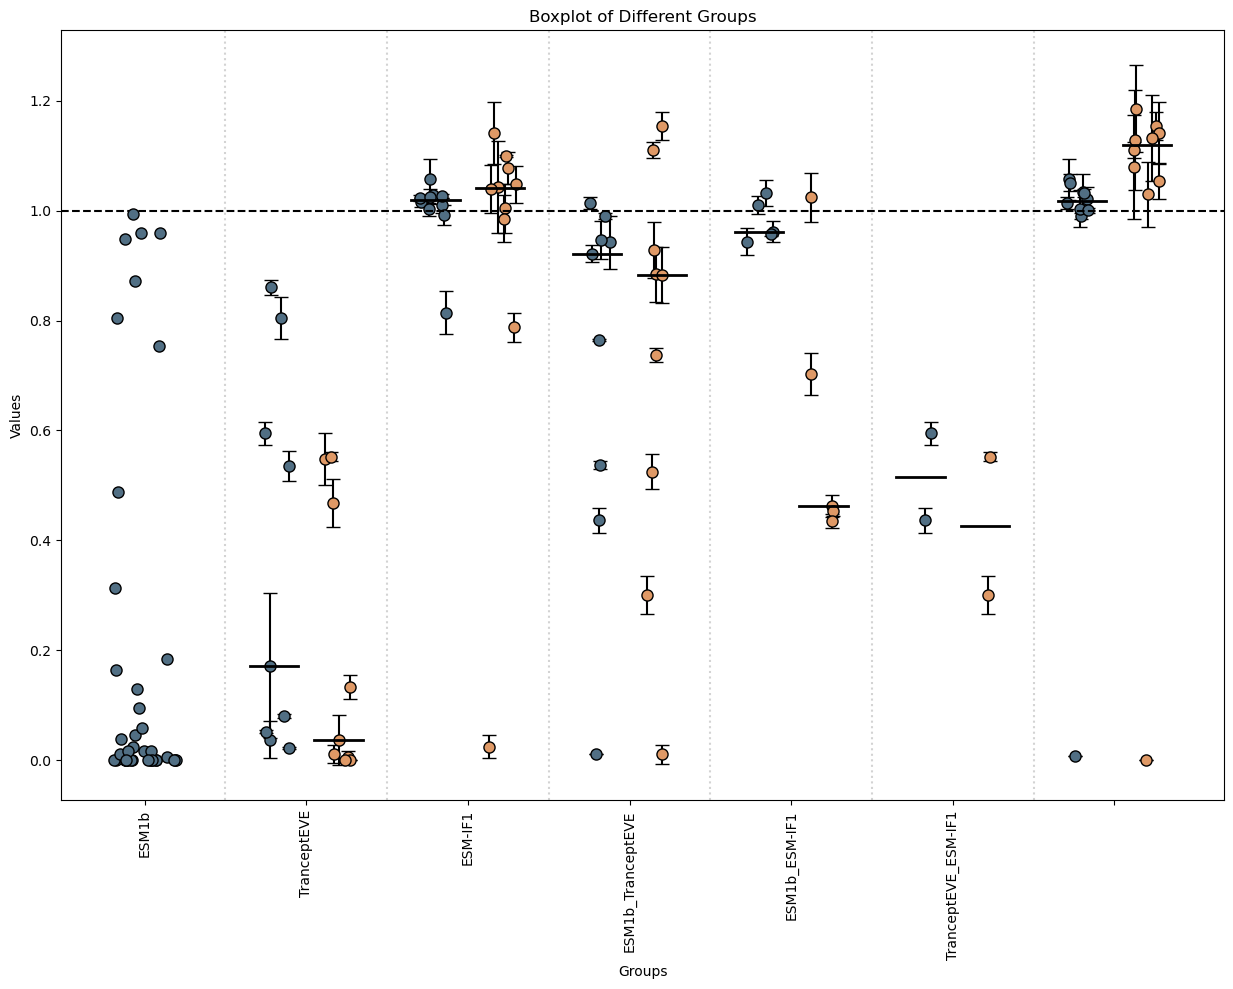

In [212]:
color_ = ['#516F84', '#DF9966']

fig, ax = plt.subplots(figsize=(15, 10))
ax.errorbar(np.random.uniform(low=-1,high=1,size=40)/5,subset_180_ordered.Selection.dropna(), fmt='o',
                markerfacecolor=color_[0], markeredgecolor='black', ecolor='k', capsize=5, markersize=8)
#ax.plot([-0.5,0.5],[np.median(subset_ordered.Selection.dropna()),np.median(subset_ordered.Selection.dropna())],color=color_[0],linewidth=2)
for i, col in enumerate(subset_180_ordered.columns[1:]):
    ax.errorbar(i+1-0.2+np.random.uniform(low=-1,high=1,size=len(subset_180_mean[col]))/10, y=subset_180_mean[col], yerr=subset_180_std[col], fmt='o',
                markerfacecolor=color_[0], markeredgecolor='black', ecolor='k', capsize=5, markersize=8,zorder=1)
    ax.errorbar(i+1+0.2+np.random.uniform(low=-1,high=1,size=len(subset_2_mean[col]))/10, y=subset_2_mean[col], yerr=subset_2_std[col], fmt='o',
                markerfacecolor=color_[1], markeredgecolor='black', ecolor='k', capsize=5, markersize=8,zorder=1)
    ax.plot([i+1-0.2-0.15,i+1-0.2+0.15],[np.median(subset_180_mean[col]),np.median(subset_180_mean[col])],color='k',linewidth=2,zorder=2)
    ax.plot([i+1+0.2-0.15,i+1+0.2+0.15],[np.median(subset_2_mean[col]),np.median(subset_2_mean[col])],color='k',linewidth=2,zorder=2)
for i in range(6):
    ax.axvline(x=i+0.5, color='lightgray', linestyle=':')
ax.axhline(y=1, color='black', linestyle='--')
ax.set_xticklabels(subset_180_ordered.columns, rotation=90)
ax.set_xlabel("Groups")
ax.set_ylabel("Values")
plt.title("Boxplot of Different Groups")
plt.show()

In [ ]:
color_ = ['red', 'green', 'blue', 'orange', 'purple', 'brown','pink']

fig, ax = plt.subplots(figsize=(10, 6))
#ax.boxplot([subset_ordered[col].dropna() for col in subset_ordered.columns], showfliers=False, widths=0.8)
ax.errorbar(np.random.uniform(low=-1,high=1,size=40)/5,subset_180_ordered.Selection.dropna(), fmt='o',
                markerfacecolor=color_[0], markeredgecolor='black', ecolor='k', capsize=5, markersize=8)
#ax.plot([-0.5,0.5],[np.median(subset_ordered.Selection.dropna()),np.median(subset_ordered.Selection.dropna())],color=color_[0],linewidth=2)
for i, col in enumerate(subset_180_ordered.columns[1:]):
    ax.errorbar(i+1+np.random.uniform(low=-1,high=1,size=len(subset_180_mean[col]))/5, y=subset_180_mean[col], yerr=subset_180_std[col], fmt='o',
                markerfacecolor=color_[i+1], markeredgecolor='black', ecolor='k', capsize=5, markersize=8)
    ax.plot([i+1-0.3,i+1+0.3],[np.median(subset_180_mean[col]),np.median(subset_180_mean[col])],color=color_[i+1],linewidth=2)
ax.axhline(y=1, color='black', linestyle='--')
ax.set_xticklabels(subset_180_ordered.columns, rotation=90)
ax.set_xlabel("Groups")
ax.set_ylabel("Values")
plt.title("Boxplot of Different Groups")
plt.show()

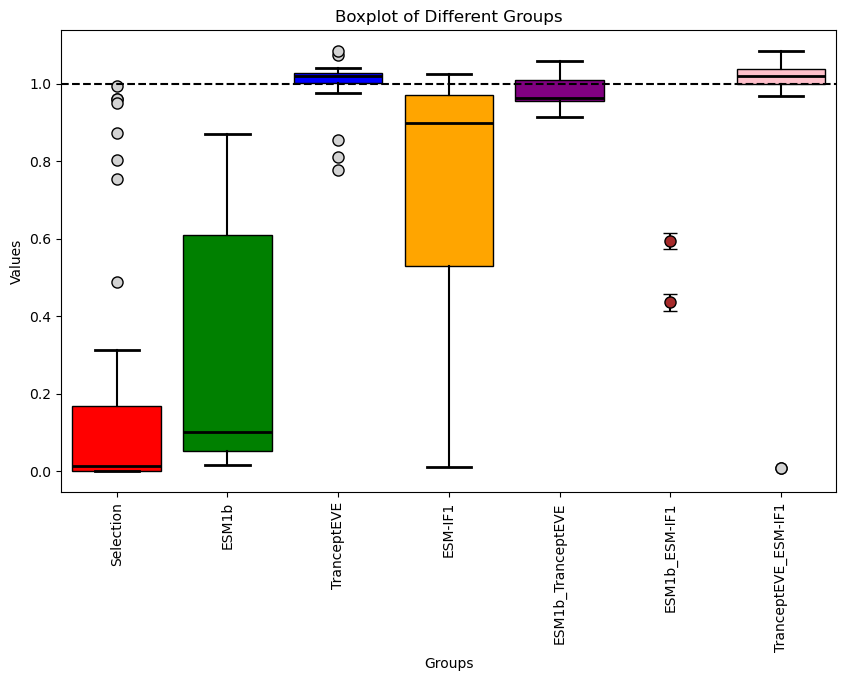

In [ ]:

color_ = ['red', 'green', 'blue', 'orange', 'purple', 'brown','pink']

fig, ax = plt.subplots(figsize=(10, 6))

x_positions = range(1, len(subset_ordered.columns) + 1)  # Adjust as needed
for i, col in enumerate(subset_ordered.columns):
    if col != 'ESM1b_ESM-IF1':
        box = ax.boxplot(subset_180_ordered[col].dropna(),positions=[x_positions[i]],
                        patch_artist=True,  # Allows color filling
                        boxprops=dict(facecolor=color_[i], color="k"),  # Box fill & outline color
                        whiskerprops=dict(color="black", linewidth=1.5),  # Whisker color
                        capprops=dict(color="k", linewidth=2),  # Cap (end line) color
                        medianprops=dict(color="black", linewidth=2),  # Median line color
                        flierprops=dict(marker="o", markerfacecolor="lightgray", markeredgecolor="black", markersize=8),  # Outlier style
                        widths=0.8  # Width of the box
                        )
    else:
        ax.errorbar([x_positions[i],x_positions[i]], y=subset_mean[col], yerr=subset_std[col], fmt='o',
                markerfacecolor=color_[i], markeredgecolor='black', ecolor='k', capsize=5, markersize=8)
ax.axhline(y=1, color='black', linestyle='--')
ax.set_xticks(x_positions)
ax.set_xticklabels(subset_ordered.columns, rotation=90)
ax.set_xlabel("Groups")
ax.set_ylabel("Values")
plt.title("Boxplot of Different Groups")
plt.show()

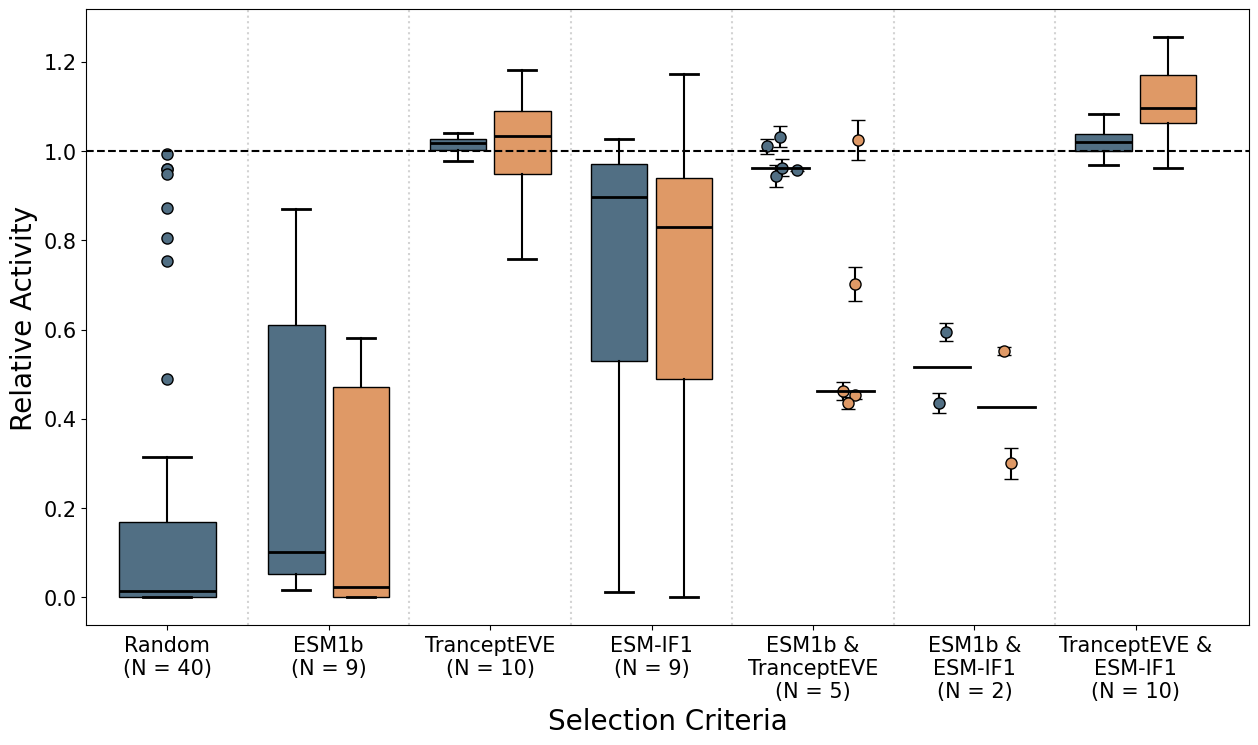

In [343]:

color_ = ['#516F84', '#DF9966']

fig, ax = plt.subplots(figsize=(15, 8))
ax.boxplot(subset_180_ordered.Selection.dropna(),positions=[0],
            patch_artist=True,  # Allows color filling
            boxprops=dict(facecolor=color_[0], color='k'),  # Box fill & outline color
            whiskerprops=dict(color="black", linewidth=1.5),  # Whisker color
            capprops=dict(color="k", linewidth=2),  # Cap (end line) color
            medianprops=dict(color="black", linewidth=2),  # Median line color
            flierprops=dict(marker="o", markerfacecolor=color_[0], markeredgecolor="black", markersize=8),  # Outlier style
            widths=0.6  # Width of the box
            )
x_positions = range(1, len(subset_180_ordered.columns[1:]) + 1)
for i, col in enumerate(subset_180_ordered.columns[1:]):
    if col != 'ESM1b_ESM-IF1' and col != 'ESM1b_TranceptEVE':
        box = ax.boxplot(subset_180_ordered[col].dropna(),positions=[x_positions[i]-0.2],
                        patch_artist=True,  # Allows color filling
                        boxprops=dict(facecolor=color_[0], color='k'),  # Box fill & outline color
                        whiskerprops=dict(color="black", linewidth=1.5),  # Whisker color
                        capprops=dict(color="k", linewidth=2),  # Cap (end line) color
                        medianprops=dict(color="black", linewidth=2),  # Median line color
                        flierprops=dict(marker="o", markerfacecolor=color_[0], markeredgecolor="black", markersize=8),  # Outlier style
                        widths=0.35,  # Width of the box
                        showfliers=False)
        box = ax.boxplot(subset_2_ordered[col].dropna(),positions=[x_positions[i]+0.2],
                        patch_artist=True,  # Allows color filling
                        boxprops=dict(facecolor=color_[1], color='k'),  # Box fill & outline color
                        whiskerprops=dict(color="black", linewidth=1.5),  # Whisker color
                        capprops=dict(color="k", linewidth=2),  # Cap (end line) color
                        medianprops=dict(color="black", linewidth=2),  # Median line color
                        flierprops=dict(marker="o", markerfacecolor=color_[1], markeredgecolor="black", markersize=8),  # Outlier style
                        widths=0.35,  # Width of the box
                        showfliers=False)
    else:
        ax.errorbar(i+1-0.2+np.random.uniform(low=-1,high=1,size=len(subset_180_mean[col]))/10, y=subset_180_mean[col], yerr=subset_180_std[col], fmt='o',
                    markerfacecolor=color_[0], markeredgecolor='black', ecolor='k', capsize=5, markersize=8,zorder=1)
        ax.errorbar(i+1+0.2+np.random.uniform(low=-1,high=1,size=len(subset_2_mean[col]))/10, y=subset_2_mean[col], yerr=subset_2_std[col], fmt='o',
                    markerfacecolor=color_[1], markeredgecolor='black', ecolor='k', capsize=5, markersize=8,zorder=1)
        ax.plot([i+1-0.2-0.175,i+1-0.2+0.175],[np.median(subset_180_mean[col]),np.median(subset_180_mean[col])],color='k',linewidth=2,zorder=2)
        ax.plot([i+1+0.2-0.175,i+1+0.2+0.175],[np.median(subset_2_mean[col]),np.median(subset_2_mean[col])],color='k',linewidth=2,zorder=2)
    
for i in range(6):
    ax.axvline(x=i+0.5, color='lightgray', linestyle=':')
ax.axhline(y=1, color='black', linestyle='--')

x_labels = ['Random\n(N = 40)', 'ESM1b\n(N = 9)', 'TranceptEVE\n(N = 10)', 'ESM-IF1\n(N = 9)', 'ESM1b &\nTranceptEVE\n(N = 5)', 'ESM1b &\nESM-IF1\n(N = 2)', 'TranceptEVE &\nESM-IF1\n(N = 10)']
ax.set_xticks(np.arange(7))
ax.set_xticklabels(x_labels, fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel("Selection Criteria", fontsize=20)
ax.set_ylabel("Relative Activity", fontsize=20)
#plt.title("Boxplot of Different Groups")
plt.show()

In [329]:
interesting_mutants = {'ESM1b': ['P165A'],
    'TranceptEVE': ['A298P','H32L'],
    'ESM-IF1': ['G37D','S166A'],
    'ESM1b_TranceptEVE': ['P285R'],
    'ESM1b_ESM-IF1': ['W103G'],
    'TranceptEVE_ESM-IF1': ['H191E']}

model_color = {'ESM1b': '#FFEFD3',
    'TranceptEVE': '#516F84',
    'ESM-IF1': '#DF9966'}

lowN_muts = ['E247S','E247D','N287T','N287Y']
int_muts = [x for xs in list(interesting_mutants.values()) for x in xs]

/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_10598/2311230407.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(lowN_muts+int_muts)
/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_10598/2311230407.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(lowN_muts+int_muts)


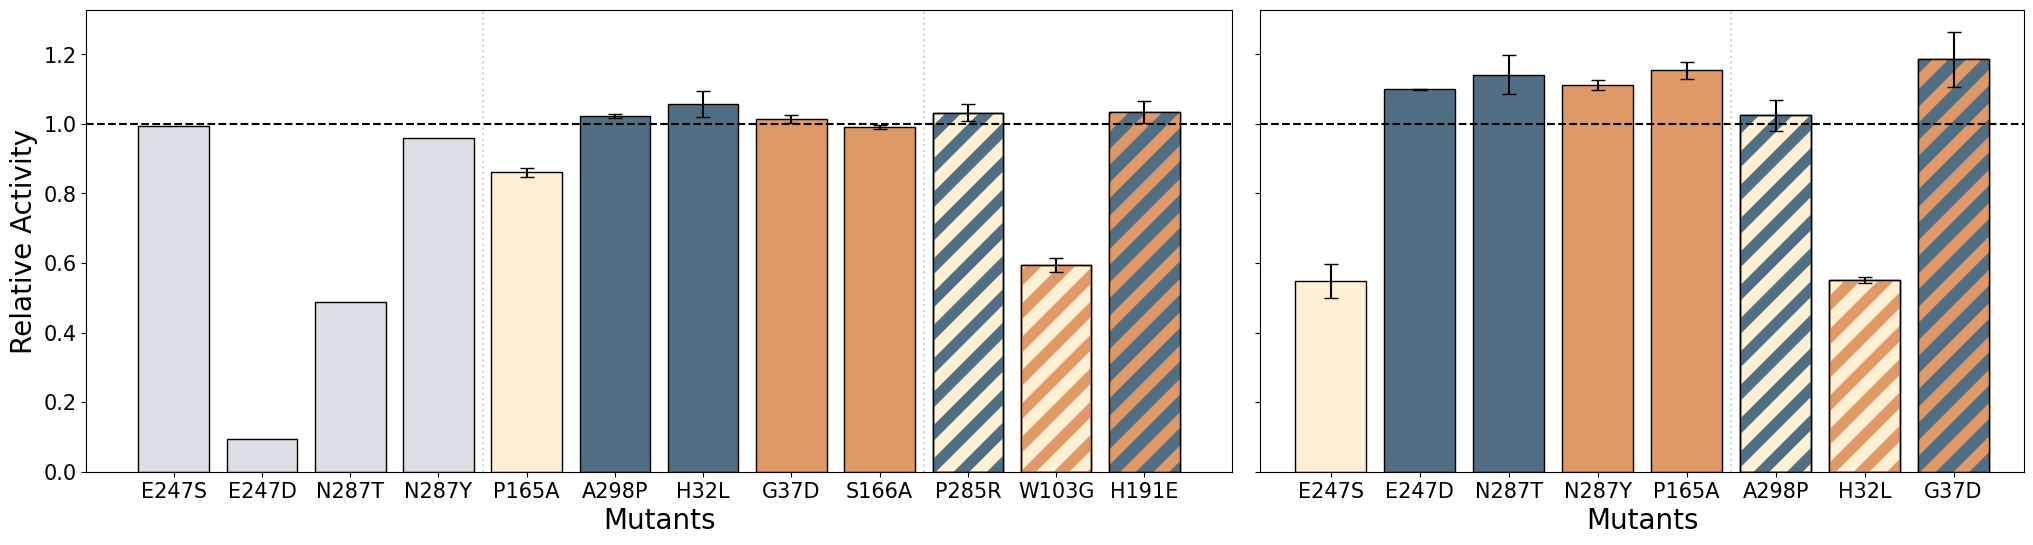

In [389]:
fig, ax= plt.subplots(ncols=2,figsize=(25,6),sharey=True,width_ratios=[12,8], gridspec_kw={'wspace': 0.03})
single_models=["ESM1b", "TranceptEVE", "ESM-IF1"]
double_models=["ESM1b_TranceptEVE", "ESM1b_ESM-IF1", "TranceptEVE_ESM-IF1"]

plt.rcParams['hatch.linewidth'] = 8  # Adjust thickness of hatches
for mut in ['HiM_010','HiM_015','HiM_031','HiM_035']:
    act_ = relact_comb[relact_comb.Sample_ID==mut].Relative_Activity
    ax[0].bar(mut,act_, edgecolor='black', color='#DCDFE5')
SAM = 300 ### Selected time, must be element of [10, 300]

for i,t in enumerate([180,2]):
    for model in single_models:
        subset = relact_var_models.loc[relact_var_models[model] & (relact_var_models["Time(min)"] == t) & (relact_var_models["SAM_conc(uM)"] == SAM)]
        for mut in interesting_mutants[model]:
            act_ = subset[subset.Protein==mut].Relative_Activity
            ax[i].bar(mut,act_.mean(), yerr=act_.std(), capsize=5,
                    edgecolor='black', color=model_color[model])
    for model in double_models:
        subset = relact_var_models.loc[relact_var_models[model] & (relact_var_models["Time(min)"] == t) & (relact_var_models["SAM_conc(uM)"] == SAM)]
        for mut in interesting_mutants[model]:
            act_ = subset[subset.Protein==mut].Relative_Activity
            ax[i].bar(mut,act_.mean(), yerr=act_.std(), capsize=5,
                    edgecolor='black', color=model_color[model.split("_")[0]])
            ax[i].bar(mut,act_.mean(), color='none',hatch='/',
                    edgecolor=model_color[model.split("_")[1]])
            ax[i].bar(mut,act_.mean(), color='none',edgecolor='black')

    
    ax[i].axhline(y=1, color='black', linestyle='--')

    ax[i].set_xticklabels(lowN_muts+int_muts)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].set_xlabel("Mutants", fontsize=20)

for x_ in [3.5,8.5]:
        ax[0].axvline(x=x_, color='lightgray', linestyle=':')

ax[1].axvline(x=4.5, color='lightgray', linestyle=':')
ax[0].set_ylabel("Relative Activity", fontsize=20)
plt.show()


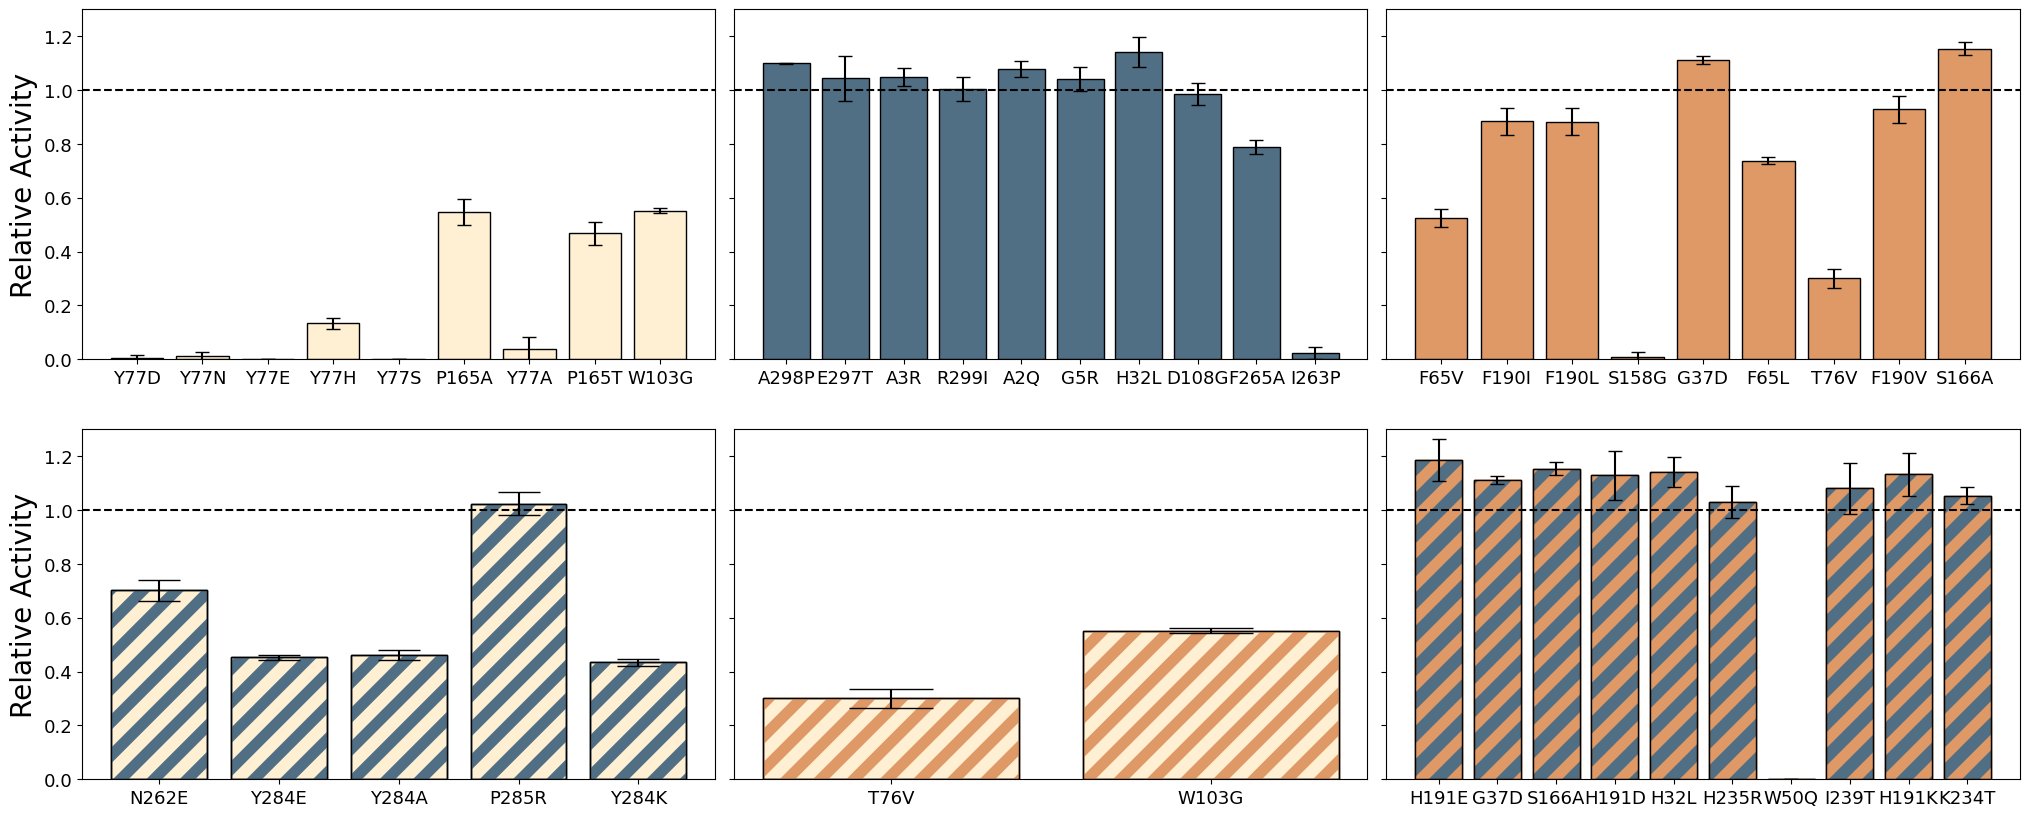

In [399]:
### Plotting - plot by model and protein

time = 2 ### Selected time, must be element of [2, 5, 180]
SAM = 300 ### Selected time, must be element of [10, 300]
capsizes = [5,5,5,15,30,5]
models=["ESM1b", "TranceptEVE", "ESM-IF1", "ESM1b_TranceptEVE", "ESM1b_ESM-IF1", "TranceptEVE_ESM-IF1"]

fig, axs=plt.subplots(2,3, figsize=(25,10),sharey=True, gridspec_kw={'wspace': 0.03,'hspace': 0.2})

axs=axs.flatten()

for i,model in enumerate(models[:3]):

    subset = relact_var_models.loc[relact_var_models[model] & (relact_var_models["Time(min)"] == time) & (relact_var_models["SAM_conc(uM)"] == SAM)]

    ### Restructure dataset and calculate mean & stddev per protein
    subset = pd.melt(subset, id_vars=["Protein", f"{model}_rank"], value_vars=["Relative_Activity"])
    plotdata = subset.groupby("Protein")["value"].agg(["mean", "std"]).reset_index()
    plotdata = plotdata.merge(subset[["Protein", f"{model}_rank"]], on="Protein", how="left").sort_values(f"{model}_rank").drop_duplicates().reset_index(drop=True)

    axs[i].bar(x=plotdata["Protein"], height=plotdata["mean"],yerr=plotdata["std"],color=model_color[model],
                edgecolor='black',capsize=capsizes[i])
    axs[i].axhline(y=1, color="black", linestyle = "--")
    axs[i].set_ylim(0,1.3)
    axs[i].tick_params(axis='both', which='major', labelsize=13)

for i,model in enumerate(models[3:]):

    subset = relact_var_models.loc[relact_var_models[model] & (relact_var_models["Time(min)"] == time) & (relact_var_models["SAM_conc(uM)"] == SAM)]

    ### Restructure dataset and calculate mean & stddev per protein
    subset = pd.melt(subset, id_vars=["Protein", f"{model}_rank"], value_vars=["Relative_Activity"])
    plotdata = subset.groupby("Protein")["value"].agg(["mean", "std"]).reset_index()
    plotdata = plotdata.merge(subset[["Protein", f"{model}_rank"]], on="Protein", how="left").sort_values(f"{model}_rank").drop_duplicates().reset_index(drop=True)
    
    axs[i+3].bar(x=plotdata["Protein"], height=plotdata["mean"],yerr=plotdata["std"],color=model_color[model.split("_")[0]],
                edgecolor='black',capsize=capsizes[i+3])
    axs[i+3].bar(x=plotdata["Protein"], height=plotdata["mean"],color='none',hatch='/',
                edgecolor=model_color[model.split("_")[1]])
    axs[i+3].bar(x=plotdata["Protein"], height=plotdata["mean"],color='none',
                edgecolor='k')
    axs[i+3].axhline(y=1, color="black", linestyle = "--")
    axs[i+3].set_ylim(0,1.3)
    axs[i+3].tick_params(axis='both', which='major', labelsize=13)

axs[0].set_ylabel("Relative Activity", fontsize=20)
axs[3].set_ylabel("Relative Activity", fontsize=20)

plt.subplots_adjust(hspace=0.5)
plt.show()

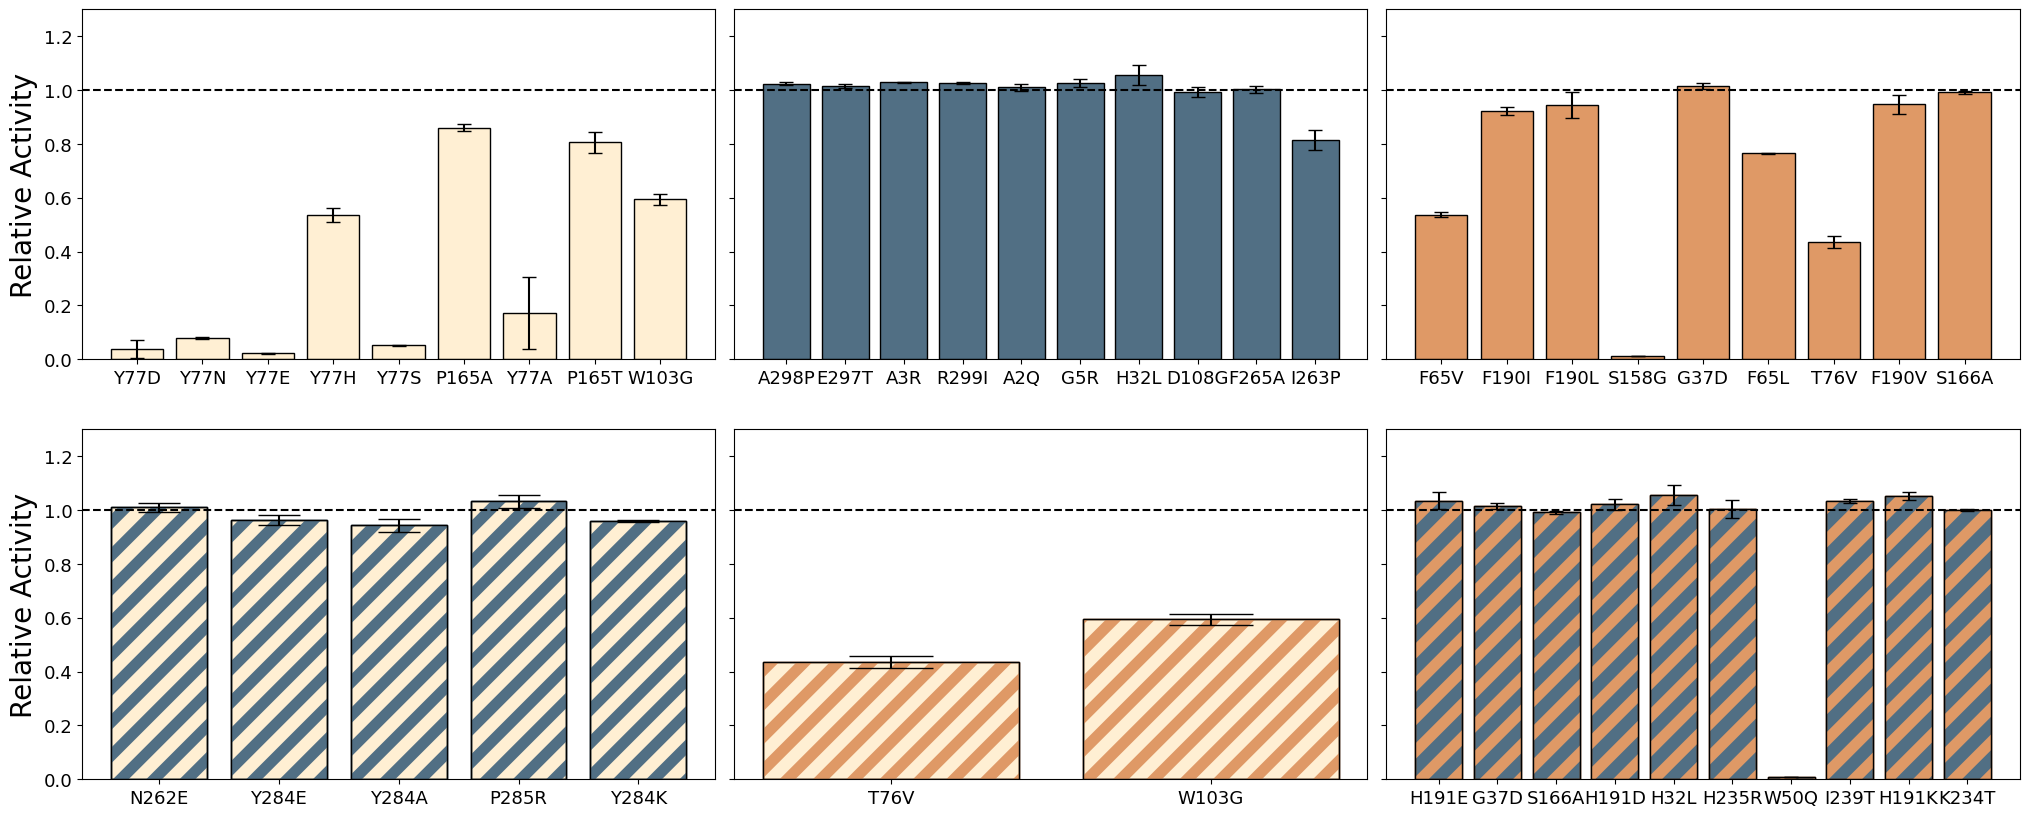

In [400]:
### Plotting - plot by model and protein

time = 180 ### Selected time, must be element of [2, 5, 180]
SAM = 300 ### Selected time, must be element of [10, 300]
capsizes = [5,5,5,15,30,5]
models=["ESM1b", "TranceptEVE", "ESM-IF1", "ESM1b_TranceptEVE", "ESM1b_ESM-IF1", "TranceptEVE_ESM-IF1"]

fig, axs=plt.subplots(2,3, figsize=(25,10),sharey=True, gridspec_kw={'wspace': 0.03,'hspace': 0.2})

axs=axs.flatten()

for i,model in enumerate(models[:3]):

    subset = relact_var_models.loc[relact_var_models[model] & (relact_var_models["Time(min)"] == time) & (relact_var_models["SAM_conc(uM)"] == SAM)]

    ### Restructure dataset and calculate mean & stddev per protein
    subset = pd.melt(subset, id_vars=["Protein", f"{model}_rank"], value_vars=["Relative_Activity"])
    plotdata = subset.groupby("Protein")["value"].agg(["mean", "std"]).reset_index()
    plotdata = plotdata.merge(subset[["Protein", f"{model}_rank"]], on="Protein", how="left").sort_values(f"{model}_rank").drop_duplicates().reset_index(drop=True)

    axs[i].bar(x=plotdata["Protein"], height=plotdata["mean"],yerr=plotdata["std"],color=model_color[model],
                edgecolor='black',capsize=capsizes[i])
    axs[i].axhline(y=1, color="black", linestyle = "--")
    axs[i].set_ylim(0,1.3)
    axs[i].tick_params(axis='both', which='major', labelsize=13)

for i,model in enumerate(models[3:]):

    subset = relact_var_models.loc[relact_var_models[model] & (relact_var_models["Time(min)"] == time) & (relact_var_models["SAM_conc(uM)"] == SAM)]

    ### Restructure dataset and calculate mean & stddev per protein
    subset = pd.melt(subset, id_vars=["Protein", f"{model}_rank"], value_vars=["Relative_Activity"])
    plotdata = subset.groupby("Protein")["value"].agg(["mean", "std"]).reset_index()
    plotdata = plotdata.merge(subset[["Protein", f"{model}_rank"]], on="Protein", how="left").sort_values(f"{model}_rank").drop_duplicates().reset_index(drop=True)
    
    axs[i+3].bar(x=plotdata["Protein"], height=plotdata["mean"],yerr=plotdata["std"],color=model_color[model.split("_")[0]],
                edgecolor='black',capsize=capsizes[i+3])
    axs[i+3].bar(x=plotdata["Protein"], height=plotdata["mean"],color='none',hatch='/',
                edgecolor=model_color[model.split("_")[1]])
    axs[i+3].bar(x=plotdata["Protein"], height=plotdata["mean"],color='none',
                edgecolor='k')
    axs[i+3].axhline(y=1, color="black", linestyle = "--")
    axs[i+3].set_ylim(0,1.3)
    axs[i+3].tick_params(axis='both', which='major', labelsize=13)

axs[0].set_ylabel("Relative Activity", fontsize=20)
axs[3].set_ylabel("Relative Activity", fontsize=20)

plt.subplots_adjust(hspace=0.5)
plt.show()

In [490]:
FlA_HIM_ESM1b=pd.read_csv('../results/ESM1b/FlA_HIM_RelAct.csv')
FlA_HIM_TranceptEVE=pd.read_csv('../results/TranceptEVE/TranceptEVE_M/FlA_HIM_RelAct.csv')
FlA_HIM_ESM_IF1=pd.read_csv('../results/ESM-IF1/FlA_HIM_RelAct.csv')
FlA_HIM_merge = pd.merge(FlA_HIM_ESM1b,FlA_HIM_TranceptEVE[['mutant','avg_score']], on='mutant',suffixes=('_ESM1b','_TranceptEVE'))
FlA_HIM_merge = pd.merge(FlA_HIM_merge,FlA_HIM_ESM_IF1[['mutant','esmif1_ll']], on='mutant')

In [502]:
t = 2
SAM = 300
subset = relact_var_models[(relact_var_models["Time(min)"] == t) & (relact_var_models["SAM_conc(uM)"] == SAM)]
subset = subset[['Protein','Relative_Activity','ESM1b_score','TranceptEVE_score','ESM-IF1_score','ESM1b','TranceptEVE','ESM-IF1','ESM1b_TranceptEVE','ESM1b_ESM-IF1','TranceptEVE_ESM-IF1']]

# Compute mean and std for "Relative_Activity"
df_stats = subset.groupby("Protein", as_index=False).agg(
    Relative_Activity_mean=("Relative_Activity", "mean"),
    Relative_Activity_std=("Relative_Activity", "std")
)

# Merge with a representative row from the original dataset to keep other columns
df_other = subset.groupby("Protein").first().reset_index()

# Merge back with mean and std values
df_final = df_other.merge(df_stats, on="Protein").drop('Relative_Activity', axis=1)
df_ESM1b=df_final[df_final['ESM1b']+df_final['ESM1b_TranceptEVE']+df_final['ESM1b_ESM-IF1']]
df_TranceptEVE=df_final[df_final['TranceptEVE']+df_final['ESM1b_TranceptEVE']+df_final['TranceptEVE_ESM-IF1']]
df_ESM_IF1=df_final[df_final['ESM-IF1']+df_final['ESM1b_ESM-IF1']+df_final['TranceptEVE_ESM-IF1']]

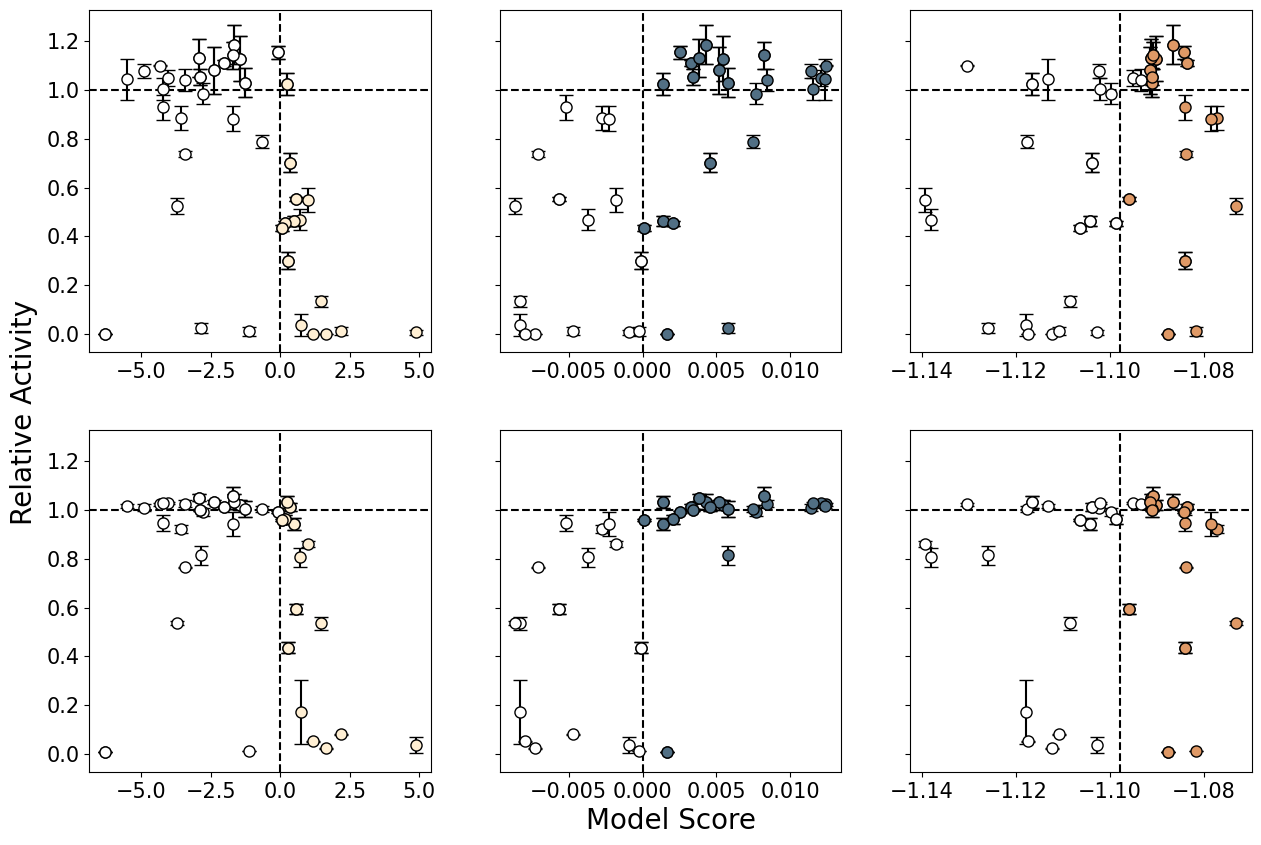

In [513]:
wts = [0,0,-1.097821,0,0,-1.097821]

fig, ax = plt.subplots(ncols=3,nrows=2,figsize=(15, 10),sharey=True)
ax=ax.flatten()

t = 2
SAM = 300
subset = relact_var_models[(relact_var_models["Time(min)"] == t) & (relact_var_models["SAM_conc(uM)"] == SAM)]
subset = subset[['Protein','Relative_Activity','ESM1b_score','TranceptEVE_score','ESM-IF1_score','ESM1b','TranceptEVE','ESM-IF1','ESM1b_TranceptEVE','ESM1b_ESM-IF1','TranceptEVE_ESM-IF1']]

# Compute mean and std for "Relative_Activity"
df_stats = subset.groupby("Protein", as_index=False).agg(
    Relative_Activity_mean=("Relative_Activity", "mean"),
    Relative_Activity_std=("Relative_Activity", "std")
)

# Merge with a representative row from the original dataset to keep other columns
df_other = subset.groupby("Protein").first().reset_index()

# Merge back with mean and std values
df_final = df_other.merge(df_stats, on="Protein").drop('Relative_Activity', axis=1)
df_ESM1b=df_final[df_final['ESM1b']+df_final['ESM1b_TranceptEVE']+df_final['ESM1b_ESM-IF1']]
df_TranceptEVE=df_final[df_final['TranceptEVE']+df_final['ESM1b_TranceptEVE']+df_final['TranceptEVE_ESM-IF1']]
df_ESM_IF1=df_final[df_final['ESM-IF1']+df_final['ESM1b_ESM-IF1']+df_final['TranceptEVE_ESM-IF1']]

ax[0].errorbar(df_TranceptEVE['ESM1b_score'],df_TranceptEVE['Relative_Activity_mean'],yerr=df_TranceptEVE['Relative_Activity_std'],
               fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[0].errorbar(df_ESM_IF1['ESM1b_score'],df_ESM_IF1['Relative_Activity_mean'],yerr=df_ESM_IF1['Relative_Activity_std'],
               fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[0].errorbar(df_ESM1b['ESM1b_score'],df_ESM1b['Relative_Activity_mean'],yerr=df_ESM1b['Relative_Activity_std'],
               fmt='o',markerfacecolor=model_color['ESM1b'], markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)

ax[1].errorbar(df_ESM1b['TranceptEVE_score'],df_ESM1b['Relative_Activity_mean'],yerr=df_ESM1b['Relative_Activity_std'],
                fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[1].errorbar(df_ESM_IF1['TranceptEVE_score'],df_ESM_IF1['Relative_Activity_mean'],yerr=df_ESM_IF1['Relative_Activity_std'],
                fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[1].errorbar(df_TranceptEVE['TranceptEVE_score'],df_TranceptEVE['Relative_Activity_mean'],yerr=df_TranceptEVE['Relative_Activity_std'],
                fmt='o',markerfacecolor=model_color['TranceptEVE'], markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)

ax[2].errorbar(df_ESM1b['ESM-IF1_score'],df_ESM1b['Relative_Activity_mean'],yerr=df_ESM1b['Relative_Activity_std'],
                fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[2].errorbar(df_TranceptEVE['ESM-IF1_score'],df_TranceptEVE['Relative_Activity_mean'],yerr=df_TranceptEVE['Relative_Activity_std'],
                fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[2].errorbar(df_ESM_IF1['ESM-IF1_score'],df_ESM_IF1['Relative_Activity_mean'],yerr=df_ESM_IF1['Relative_Activity_std'],
                fmt='o',markerfacecolor=model_color['ESM-IF1'], markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)

t = 180
SAM = 300
subset = relact_var_models[(relact_var_models["Time(min)"] == t) & (relact_var_models["SAM_conc(uM)"] == SAM)]
subset = subset[['Protein','Relative_Activity','ESM1b_score','TranceptEVE_score','ESM-IF1_score','ESM1b','TranceptEVE','ESM-IF1','ESM1b_TranceptEVE','ESM1b_ESM-IF1','TranceptEVE_ESM-IF1']]

# Compute mean and std for "Relative_Activity"
df_stats = subset.groupby("Protein", as_index=False).agg(
    Relative_Activity_mean=("Relative_Activity", "mean"),
    Relative_Activity_std=("Relative_Activity", "std")
)

# Merge with a representative row from the original dataset to keep other columns
df_other = subset.groupby("Protein").first().reset_index()

# Merge back with mean and std values
df_final = df_other.merge(df_stats, on="Protein").drop('Relative_Activity', axis=1)
df_ESM1b=df_final[df_final['ESM1b']+df_final['ESM1b_TranceptEVE']+df_final['ESM1b_ESM-IF1']]
df_TranceptEVE=df_final[df_final['TranceptEVE']+df_final['ESM1b_TranceptEVE']+df_final['TranceptEVE_ESM-IF1']]
df_ESM_IF1=df_final[df_final['ESM-IF1']+df_final['ESM1b_ESM-IF1']+df_final['TranceptEVE_ESM-IF1']]

ax[3].errorbar(df_TranceptEVE['ESM1b_score'],df_TranceptEVE['Relative_Activity_mean'],yerr=df_TranceptEVE['Relative_Activity_std'],
               fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[3].errorbar(df_ESM_IF1['ESM1b_score'],df_ESM_IF1['Relative_Activity_mean'],yerr=df_ESM_IF1['Relative_Activity_std'],
               fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[3].errorbar(df_ESM1b['ESM1b_score'],df_ESM1b['Relative_Activity_mean'],yerr=df_ESM1b['Relative_Activity_std'],
               fmt='o',markerfacecolor=model_color['ESM1b'], markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)

ax[4].errorbar(df_ESM1b['TranceptEVE_score'],df_ESM1b['Relative_Activity_mean'],yerr=df_ESM1b['Relative_Activity_std'],
                fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[4].errorbar(df_ESM_IF1['TranceptEVE_score'],df_ESM_IF1['Relative_Activity_mean'],yerr=df_ESM_IF1['Relative_Activity_std'],
                fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[4].errorbar(df_TranceptEVE['TranceptEVE_score'],df_TranceptEVE['Relative_Activity_mean'],yerr=df_TranceptEVE['Relative_Activity_std'],
                fmt='o',markerfacecolor=model_color['TranceptEVE'], markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)

ax[5].errorbar(df_ESM1b['ESM-IF1_score'],df_ESM1b['Relative_Activity_mean'],yerr=df_ESM1b['Relative_Activity_std'],
                fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[5].errorbar(df_TranceptEVE['ESM-IF1_score'],df_TranceptEVE['Relative_Activity_mean'],yerr=df_TranceptEVE['Relative_Activity_std'],
                fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[5].errorbar(df_ESM_IF1['ESM-IF1_score'],df_ESM_IF1['Relative_Activity_mean'],yerr=df_ESM_IF1['Relative_Activity_std'],
                fmt='o',markerfacecolor=model_color['ESM-IF1'], markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)

for i in range(6):
    ax[i].axhline(y=1, color='black', linestyle='--')
    ax[i].axvline(x=wts[i], color='black', linestyle='--')
    
    ax[i].set_box_aspect(1)
    ax[i].tick_params(axis='both', which='major', labelsize=15)

ax[3].set_ylabel("Relative Activity", fontsize=20)
ax[4].set_xlabel("Model Score", fontsize=20)
ax[3].yaxis.set_label_coords(-0.15, 1.05)




In [504]:
t = 180
SAM = 300
subset = relact_var_models[(relact_var_models["Time(min)"] == t) & (relact_var_models["SAM_conc(uM)"] == SAM)]
subset = subset[['Protein','Relative_Activity','ESM1b_score','TranceptEVE_score','ESM-IF1_score','ESM1b','TranceptEVE','ESM-IF1','ESM1b_TranceptEVE','ESM1b_ESM-IF1','TranceptEVE_ESM-IF1']]

# Compute mean and std for "Relative_Activity"
df_stats = subset.groupby("Protein", as_index=False).agg(
    Relative_Activity_mean=("Relative_Activity", "mean"),
    Relative_Activity_std=("Relative_Activity", "std")
)

# Merge with a representative row from the original dataset to keep other columns
df_other = subset.groupby("Protein").first().reset_index()

# Merge back with mean and std values
df_final = df_other.merge(df_stats, on="Protein").drop('Relative_Activity', axis=1)
df_ESM1b=df_final[df_final['ESM1b']+df_final['ESM1b_TranceptEVE']+df_final['ESM1b_ESM-IF1']]
df_TranceptEVE=df_final[df_final['TranceptEVE']+df_final['ESM1b_TranceptEVE']+df_final['TranceptEVE_ESM-IF1']]
df_ESM_IF1=df_final[df_final['ESM-IF1']+df_final['ESM1b_ESM-IF1']+df_final['TranceptEVE_ESM-IF1']]

Text(0, 0.5, 'Relative Activity')

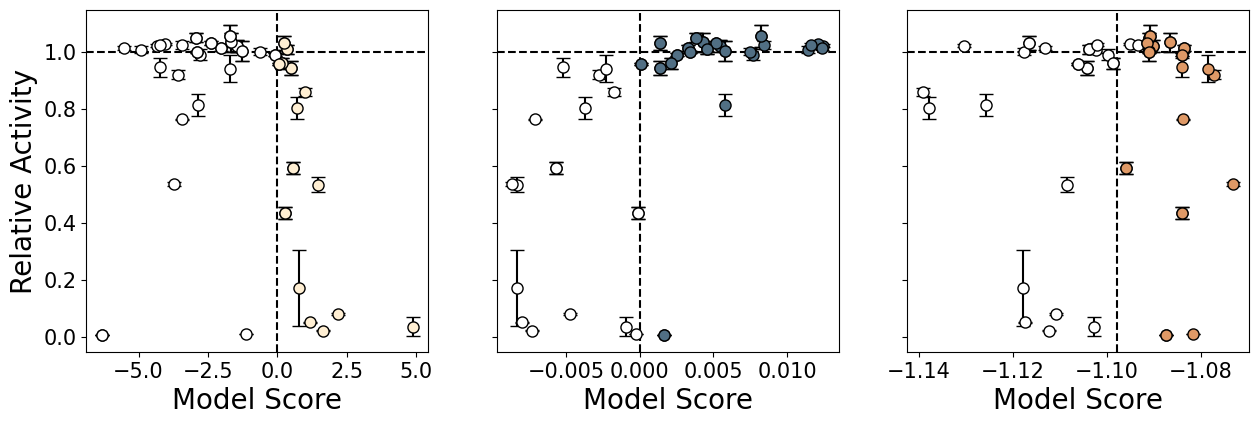

In [505]:
wts = [0,0,-1.097821]

fig, ax = plt.subplots(ncols=3,figsize=(15, 5),sharey=True)

ax[0].errorbar(df_TranceptEVE['ESM1b_score'],df_TranceptEVE['Relative_Activity_mean'],yerr=df_TranceptEVE['Relative_Activity_std'],
               fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[0].errorbar(df_ESM_IF1['ESM1b_score'],df_ESM_IF1['Relative_Activity_mean'],yerr=df_ESM_IF1['Relative_Activity_std'],
               fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[0].errorbar(df_ESM1b['ESM1b_score'],df_ESM1b['Relative_Activity_mean'],yerr=df_ESM1b['Relative_Activity_std'],
               fmt='o',markerfacecolor=model_color['ESM1b'], markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
# ax[0].errorbar(FlA_HIM_merge['esm1b_t33_650M_UR50S'],FlA_HIM_merge.DMS_score/100,
#               fmt='o',markerfacecolor='#DCDFE5', markeredgecolor='black',markersize=8)

ax[1].errorbar(df_ESM1b['TranceptEVE_score'],df_ESM1b['Relative_Activity_mean'],yerr=df_ESM1b['Relative_Activity_std'],
                fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[1].errorbar(df_ESM_IF1['TranceptEVE_score'],df_ESM_IF1['Relative_Activity_mean'],yerr=df_ESM_IF1['Relative_Activity_std'],
                fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[1].errorbar(df_TranceptEVE['TranceptEVE_score'],df_TranceptEVE['Relative_Activity_mean'],yerr=df_TranceptEVE['Relative_Activity_std'],
                fmt='o',markerfacecolor=model_color['TranceptEVE'], markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
# ax[1].errorbar(FlA_HIM_merge['avg_score'],FlA_HIM_merge.DMS_score/100,
#                 fmt='o',markerfacecolor='#DCDFE5', markeredgecolor='black',markersize=8)

ax[2].errorbar(df_ESM1b['ESM-IF1_score'],df_ESM1b['Relative_Activity_mean'],yerr=df_ESM1b['Relative_Activity_std'],
                fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[2].errorbar(df_TranceptEVE['ESM-IF1_score'],df_TranceptEVE['Relative_Activity_mean'],yerr=df_TranceptEVE['Relative_Activity_std'],
                fmt='o',markerfacecolor='white', markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
ax[2].errorbar(df_ESM_IF1['ESM-IF1_score'],df_ESM_IF1['Relative_Activity_mean'],yerr=df_ESM_IF1['Relative_Activity_std'],
                fmt='o',markerfacecolor=model_color['ESM-IF1'], markeredgecolor='black',markersize=8,
               ecolor='k', capsize=5)
# ax[2].errorbar(FlA_HIM_merge['esmif1_ll'],FlA_HIM_merge.DMS_score/100,
#                 fmt='o',markerfacecolor='#DCDFE5', markeredgecolor='black',markersize=8)

for i in range(3):
    ax[i].axhline(y=1, color='black', linestyle='--')
    ax[i].axvline(x=wts[i], color='black', linestyle='--')
    ax[i].set_xlabel("Model Score", fontsize=20)
    ax[i].set_box_aspect(1)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
ax[0].set_ylabel("Relative Activity", fontsize=20)


